# Q3 Real Life Data Set
    by Jacob Williams
    id 260400597
    email jacob.williams@mail.mcgill.ca
    for Applied Machine Learning - COMP 552



In [1]:
#command to turn on autocomplete in jupyter to make my life easier
%config IPCompleter.greedy=True 

## 1.  Cleaning Data 

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import pylab
from numpy.linalg import inv

TrnDf = pd.read_csv('Data\Q3data\q3data_all.csv', index_col=False)


#print(TrnDf)
#TrnDf.apply(pd.to_numeric)

#categorical variables a little lazy and not developing their own binary dimensions
TrnDf.pop('state')
TrnDf.pop('county')
TrnDf.pop('community')
TrnDf.pop('communityname')



def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

'''
This function will take a 
'''
def cleanData(df):
    #
    df = df[df.applymap(isnumber)]
    df = df.replace(to_replace=False , value=np.nan)
    
    # handles int or string version of numbers
    df= df.astype(dtype='float64')


    clmMns = df.mean(axis=0)
    clmStd = df.std(axis=0)

    print(df.shape)

    print(clmMns.shape)

    numrows = df.shape[0]
    
    lostLbls = []
    
    #clmLbls = list(clmMeans.axes.values)
    #print(clmLbls)
    for clm in df:
        if clm in clmMns:
            avg = clmMns.loc[clm]
            std = clmStd.loc[clm]
            for row in range(numrows):
                isnan = df.loc[row,clm]
                #nan!=nan returns true in python
                if (isnan!=isnan):
                    df.at[row,clm]=np.random.normal(avg,std)

    return df




TrnDf = cleanData(TrnDf)
TrnDf.to_csv('Data\Q3data\q3cleaned.csv', index=False)
print(TrnDf.shape)

(1994, 124)
(124,)
(1994, 124)


## 2.  Fitting With Crossover Validation 

### Preparing K-Folds files 

In [3]:
'''
Function largely helped by stack overflow below
#https://stackoverflow.com/questions/21333832/how-to-save-pandas-groups-to-separate-files
'''
def groupSplitDf(df, grpClm, exprtPath):
    #we have 10 folds listed in the data file and are requested to do 80-20 split,
    # so we must split the files into 5 folds
    grouped = df.groupby([grpClm])
    
    for grpItem, group in grouped:
        if(grpItem%2==1):
            fldNum = int(grpItem/2)+1
            exprtFile =  exprtPath+str(fldNum)+'.csv'
            cmbndDf = group
        else:
            cmbndDf = pd.concat([cmbndDf, group])
            cmbndDf.to_csv(exprtFile, index=False)
        

'''
This function will read through seperated fold files and will seperate out
the specified fold number into test X and Y numpy matrices.  
It will agglomerate the rest of the folds together into a training X & Y numpy
matrix.  The Y column must be the last column in the data to function properly
and the fold number must be specified as last characters in the file names.
'''
def cvldTrnMkr(fldClm, numFld, tstFld, genericFile):
    fldFile = genericFile + str(tstFld) +'.csv'
    
    trnDf = pd.read_csv(fldFile, index_col=False)
    dfEmpty = True
    
    for fld in range(1,numFld+1,1):
        fldFile = genericFile + str(fld) +'.csv'
        if (dfEmpty and fld != tstFld ):
            dfEmpty = False
            trnDf = pd.read_csv(fldFile, index_col=False)
        
        elif(fld!=tstFld):
            trnDf = pd.concat([trnDf, pd.read_csv(fldFile, index_col=False)])

    trnDf.pop(fldClm)
    trnDf = trnDf.as_matrix()
 
    Xtrn = trnDf[:,0:-1]
    Ytrn = trnDf[:,-1]
    
    return Xtrn, Ytrn

def cvldTstMkr(fldClm, numFld, tstFld, genericFile):
    fldFile = genericFile + str(tstFld) +'.csv'
    tstDf = pd.read_csv(fldFile, index_col=False)
    tstDf.pop(fldClm)
    tstDf = tstDf.as_matrix()

    Xtst = tstDf[:,0:-1]
    Ytst = tstDf[:,-1]
    return  Xtst, Ytst

def getFileHeader(file):
    tmpDf = pd.read_csv(file,index_col=None,nrows=1)
    tmpDf.pop('fold')
    tmpDf.pop('ViolentCrimesPerPop')
    hdr = list(tmpDf.columns.values)
    hdr = ['ConstantTerm']+hdr
    return hdr
    
        
foldFlsPth = 'Data\Q3data\q3fold_'
groupSplitDf(TrnDf, 'fold', foldFlsPth)

### Fitting Functions

In [22]:
#equation to calculate MSE error
def errMSE(X, Y, W):
    prt1 = np.subtract(Y, np.dot(X,W))
    return np.dot(prt1.transpose(),prt1)

#modified from Q1 and Q2 to be able to handle input X with multiple
# features, adds 1 column for constant term
def nDegExpansion(X, n):
    #n = n #adding 1 for the constant variables
    numrows = X.shape[0]
    numclms = X.shape[1]
    X_m = np.zeros((numrows, numclms+1)) #add 1 for constant term
    cnstnt = np.ones(numrows)
    X_m[:,0]=cnstnt
    
    for r in range(numrows):
        for c in range(0,numclms):
            for i in range(1,n+1): #add 1 for constant term
                #print(c*n+i)
                X_m[r,c*n+i] = X[r,c]**i

    return X_m

#equation to calculate MSE error
def errMSE(X, Y, W):
    prt1 = np.subtract(Y, np.dot(X,W))
    return np.dot(prt1.transpose(),prt1)

#takes input x, y, and empty weight matrix and fills in the W matrix
#also prints out the predicted Y and W to csv files
def fitModel(X, Y):
    prt1 = inv(np.dot(X.transpose(), X))
    prt2 = np.dot(prt1, X.transpose())
    W = np.dot(prt2, Y)
    return W

### Cross Over Fitting Function 

In [24]:
def crossOverFit(fldClm, numFld, genericFile, n):
    wLst =[]
    mse = np.zeros(numFld)
    
    for fld in range(0,numFld):
        Xtrn, Ytrn  = cvldTrnMkr(fldClm, numFld, fld+1, genericFile)
        Xtst, Ytst = cvldTstMkr(fldClm, numFld, fld+1, genericFile)

        X_m_trn = nDegExpansion(Xtrn, n)
        X_m_tst = nDegExpansion(Xtst, n)        

        print("Training ", fld)
        Wtrn = fitModel(X_m_trn, Ytrn, )
        mse[fld] = errMSE(X_m_tst, Ytst, Wtrn)
        
        wLst.append(Wtrn)
    
    fldFile = genericFile + str(fld) +'.csv'
    hdrs = getFileHeader(fldFile)
    
    numClms = wLst[0].shape[0]
    numRows = len(wLst)
    wMtrx = np.zeros((numRows, numClms))
    for i in range(numRows):
        wMtrx[i,:]=wLst[i]
        
    
    fldFile = genericFile + 'ClmWeights.csv'
    cmbndDf = pd.DataFrame(data=wMtrx, columns=hdrs)
    cmbndDf.to_csv(fldFile, index=False)
        
        
    return np.mean(mse)

stepSize = 5e-6
iterations = 60
batchSize = 20

crossOverFit('fold', 5, foldFlsPth, 1)

Training  0
Training  1
Training  2
Training  3
Training  4


8.3496867842102329

## 3  Ridge Regression and Feature Importance

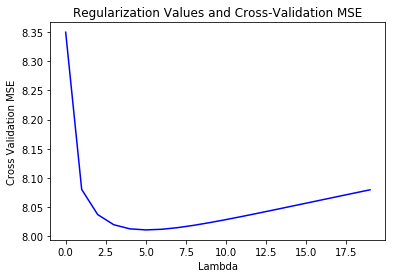

Best fit Lambda  5  Mse Error of  [8.3496867842102329, 8.0801894739812337, 8.0370673802691055, 8.019721919218922, 8.0126490375148141, 8.0107868538134728, 8.0118718421601347, 8.0147268275167338, 8.0186831449955172, 8.023338547107306, 8.0284412450819307, 8.0338290971527062, 8.0393955621364057, 8.0450696703930724, 8.0508037738106903, 8.0565658147439354, 8.0623343192890555, 8.0680950843052948, 8.0738389451550212, 8.0795602484903153]


In [33]:
def fitModelRidge(X, Y, lmda):
    prt1 = np.dot(X.transpose(),X)
    prt2 = np.multiply(np.identity(prt1.shape[0]), lmda)
    prt3 = inv(np.add(prt1,prt2))
    prt4 = np.dot(prt3,X.transpose())
    W = np.dot(prt4, Y)
    return W

def crossOverFitRidge(fldClm, numFld, genericFile, n, lmda):
    wLst =[]
    mse = np.zeros(numFld)
    
    for fld in range(0,numFld):
        Xtrn, Ytrn  = cvldTrnMkr(fldClm, numFld, fld+1, genericFile)
        Xtst, Ytst = cvldTstMkr(fldClm, numFld, fld+1, genericFile)

        X_m_trn = nDegExpansion(Xtrn, n)
        X_m_tst = nDegExpansion(Xtst, n)        

        Wtrn = fitModelRidge(X_m_trn,Ytrn, lmda)
        mse[fld] = errMSE(X_m_tst, Ytst, Wtrn)
        
        wLst.append(Wtrn)   
    
    numClms = wLst[0].shape[0]
    numRows = len(wLst)
    wMtrx = np.zeros((numRows, numClms))
    for i in range(numRows):
        wMtrx[i,:]=wLst[i]
        
    return np.mean(mse), wMtrx

def lmdaFndr(fldClm, numFld, genericFile, n, lmdaStrt, lmdaEnd, lmdDlta):
    lmdaLst = []
    mseLst = []
    wLst =[] #will be a list of weight list from cross Over Fit Ridge
    lmda = lmdaStrt
    while lmda < lmdaEnd:
        lmdaLst.append(lmda)
        lmda += lmdDlta
    
    for lmda in lmdaLst:
        #print("Training Lamda Value", lmda)
        mse, W = crossOverFitRidge(fldClm, numFld, genericFile, n, lmda)
        mseLst.append(mse)
        wLst.append(W)
        
        
    #recording Feature Weight information
    fldFile = genericFile + str(1) +'.csv'
    hdrs = getFileHeader(fldFile)
    
    #graphing info used for debugging 
    plt.title('Regularization Values and Cross-Validation MSE') 
    plt.xlabel('Lambda')
    plt.ylabel('Cross Validation MSE')
    plt.plot(lmdaLst, mseLst, 'b')
    
    plt.show()
    
    bstFit = mseLst.index(min(mseLst))
    print("Best fit Lambda " ,bstFit ," Mse Error of ", mseLst[bstFit])
    fldFile = genericFile + 'ClmLmdaWeights.csv'
    cmbndDf = pd.DataFrame(data=wLst[bstFit], columns=hdrs)
    cmbndDf.to_csv(fldFile, index=False)
    
    return wLst[bstFit]

fullWeights = lmdaFndr('fold', 5, foldFlsPth, 1, 0,20, .25)

### Fitting Reduced Features 

In [ ]:

rdcdDf = pd.read_csv('Data\Q3data\Rdcd\q3JacobFtrs.csv', index_col=False)
foldFlsPth = 'Data\Q3data\Rdcd\q3fold_'
groupSplitDf(TrnDf, 'fold', foldFlsPth)


